# Fig. 3: Shape descriptors used to measure phosphene variability

In [1]:
import os
import numpy as np
import pandas as pd

import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-08-22 16:17:10,914 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjects = subjectdata.index.sort_values()

In [3]:
Xy = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))

In [4]:
# Split data into compact / elongated shapes:
Xy['elongated'] = pd.Series(Xy['eccentricity'] >= np.sqrt(0.5), index=Xy.index)

In [5]:
descriptors = ['area', 'orientation', 'eccentricity']
ylabels = ['area (pixels)', 'orientation (deg)', 'elongation']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

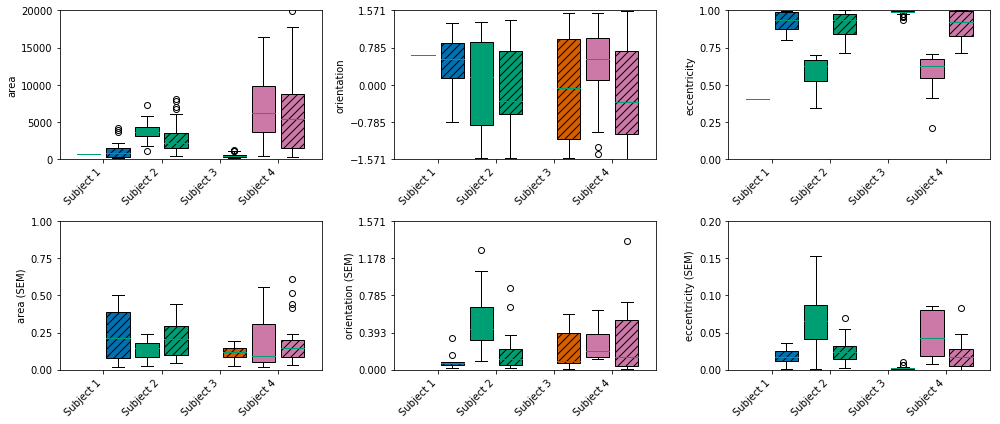

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=len(descriptors), figsize=(14, 6))

ylimits = [[0, 20000], [-np.pi/2, np.pi/2], [0, 1]]
for ax, desc, ylim in zip(axes[0], descriptors, ylimits):
    for s, (subject, color) in enumerate(zip(subjects, colors)):
        Xys = Xy[Xy.subject == subject]
        idx_compact = Xys.eccentricity < np.sqrt(0.5) #Xys.eccentricity.median()
        bp = ax.boxplot([Xys.loc[idx_compact, desc],
                        Xys.loc[~idx_compact, desc]],
                       positions=[s, s + 0.5], widths=0.4, patch_artist=True)
#         bp['boxes'][0].set_hatch('\\\\')
        bp['boxes'][1].set_hatch('///')
        [patch.set_facecolor(color) for patch in bp['boxes']]
        [patch.set_edgecolor('k') for patch in bp['boxes']]
    ax.set_xlim(-0.5, 4)
    ax.set_xticks(np.arange(len(subjects)) + 0.25)
    ax.set_xticklabels([s.replace("S", "Subject ") for s in subjects], ha='right', rotation=45)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_ylabel(desc)
    
ylimits = [[0, 1], [0, np.pi/2], [0, 0.2]]
for ax, desc, ylim in zip(axes[1], descriptors, ylimits):
    for s, (subject, color) in enumerate(zip(subjects, colors)):
        Xys = Xy[Xy.subject == subject]
        idx_compact = Xys.eccentricity < np.sqrt(0.5) #Xys.eccentricity.median()
        comp = Xys.loc[idx_compact, ['electrode', desc]].groupby('electrode')
        elon = Xys.loc[~idx_compact, ['electrode', desc]].groupby('electrode')
        if desc == 'area':
            bp = ax.boxplot([(comp.sem() / comp.mean()).dropna().values,
                             (elon.sem() / elon.mean()).dropna().values],
                             positions=[s, s + 0.5], widths=0.4, patch_artist=True)
        else:
            bp = ax.boxplot([comp.sem().dropna().values,
                             elon.sem().dropna().values],
                             positions=[s, s + 0.5], widths=0.4, patch_artist=True)            
#         bp['boxes'][0].set_hatch('\\\\')
        bp['boxes'][1].set_hatch('///')
        [patch.set_facecolor(color) for patch in bp['boxes']]
        [patch.set_edgecolor('k') for patch in bp['boxes']]
    ax.set_xlim(-0.5, 4)
    ax.set_xticks(np.arange(len(subjects)) + 0.25)
    ax.set_xticklabels([s.replace("S", "Subject ") for s in subjects], ha='right', rotation=45)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_ylabel(desc + ' (SEM)')
    
fig.tight_layout()
fig.savefig('fig3-shape-descriptors.eps')